In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random

from JAX_isingCA_local_connectivity_xi import isingCA
import pygame
from tqdm import tqdm

pygame 2.5.0 (SDL 2.28.0, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from itertools import product

# toggle the brush between two modes (shortcut B)
BRUSH_TOGGLE = False

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
     # radial blur
    xm, ym = np.meshgrid(np.linspace(-1, 1, 2*r), np.linspace(-1, 1, 2*r))
    rm = np.sqrt(xm**2 + ym**2)
    blur = np.exp(-rm**2 / s**2)
    blur = np.where(rm <= 1., blur, 0.) # circular mask
    
    # doesn't do periodic boundaries
    # state[:, 1, xcl - r:xcl + r, ycl - r : ycl + r] -= (blur.cuda() + 1e-6) 
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]
    

    state = state.at[:, 0, idx_i, idx_j].set(1.)
        #state[:, 0, idx_i, idx_j] = np.where(rm.reshape(-1) <= 1.,
        #                                        1.,
        #                                        state[:, 0, idx_i, idx_j]
        #                                       )
    
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = np.meshgrid(np.linspace(-1, 1, 2*r), np.linspace(-1, 1, 2*r))
    rm = np.sqrt(xm**2 + ym**2)
    blur = np.exp(-rm**2 / s**2)
    blur = np.where(rm <= 1., blur, 0.) # circular mask
    
    range_x = range(xcl - r, xcl + r)
    range_y = range(ycl - r, ycl + r)
    coords = list(product(range_x, range_y))
    idx_i = [c[0] % RESX for c in coords]
    idx_j = [c[1] % RESY for c in coords]
    
    state = state.at[:, 0, idx_i, idx_j].set(-1.)
    
    return state

def WHEEL_permute(cdim_order, direction, mod):
    cdim_order = np.mod(np.add(cdim_order, direction), mod)
    
    return cdim_order
    
def WHEEL_beta(beta, direction):
    
    return beta + direction * 0.01

def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [3]:
def print_something(something):
    fps = f'{something:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

# Test

In [4]:
RADIUS=3
# BETA=1. / (RADIUS*RADIUS)
BETA=1.
RES=(300, 100)
seed = 1234
key = random.PRNGKey(seed)

ca=isingCA(key, RES=RES, BETA=BETA, RADIUS=RADIUS)
state = jax.lax.stop_gradient(ca.initGrid(key))

jit_forward = jax.jit(ca.forward)
#jit_forward = ca.forward

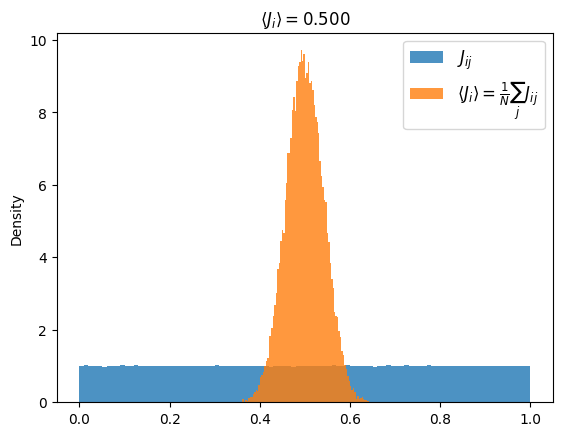

In [5]:
data = np.array(ca.rule.nearest_neighbours)
zero_mask = np.abs(data) > 1e-6
data = data[zero_mask].reshape(-1)
plt.hist(data, 100, alpha=0.8, density=True, label=r'$J_{ij}$'); #plt.yscale('log'); # plt.xscale('log')

data2 = np.array(ca.rule.nearest_neighbours)
zero_mask = np.abs(data2) > 1e-6
data2[~zero_mask] = np.nan
data2 = np.nanmean(data2, axis=1).reshape(-1)
plt.hist(data2, 100, alpha=0.8, density=True, label=r'$\langle J_i \rangle=\frac{1}{N} \sum_{j} J_{ij}$');

plt.legend(fontsize=12)
plt.ylabel('Density')

# title_str = fr'$\beta_c J_1 = 0.44; \beta_1 \langle J^{{t_f}}_i \rangle = {np.mean(data2):.3f}$'
title_str = fr'$\langle J_i \rangle = {np.mean(data2):.3f}$'
plt.title(title_str);

In [6]:
# resolution of grid
RESX=RES[0]
RESY=RES[1]

# state[0, -1] = 0.1 * torch.ones_like(state[0, -1])
# brush properties
r = RESX//20
s = 0.1

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 3

RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, state.shape[1] + 1)
beta = BETA

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

ticker = 0.
export_imgs = False
imgs = []

# stats to save
temps = []
mag = []

while running:              
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
        if event.type == pygame.MOUSEBUTTONDOWN:
            if event.button == 1:
                LMB_trigger = True
            if event.button == 3:
                RMB_trigger = True
        if event.type == pygame.MOUSEBUTTONUP:
            if event.button == 1:
                LMB_trigger = False
            if event.button == 3:
                RMB_trigger = False
                
        if event.type == pygame.MOUSEWHEEL:
            WHEEL_trigger = True
            direction = event.y
            
        if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
            # scroll through channel dims
            cdim_order = np.arange(0, state.shape[1] + 1)
                
        if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
            ca.rule.J_adapt = not ca.rule.J_adapt
    
        if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
            export_imgs = not export_imgs
        if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
            # pause/toggle time
            time_ticking = not time_ticking
            
        if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
            # start from seed 
            key = random.split(key)[0]
            state = jax.lax.stop_gradient(ca.initGrid(key))
        if event.type == pygame.KEYDOWN and event.key == pygame.K_b:
            BRUSH_TOGGLE = not BRUSH_TOGGLE
            
        if event.type == pygame.KEYDOWN and event.key == pygame.K_9:
            ca.rule.adapt_lr /= 2.
            print(f'lr: {ca.rule.adapt_lr :.4f}')
        if event.type == pygame.KEYDOWN and event.key == pygame.K_0:
            ca.rule.adapt_lr *= 2.
            print(f'lr: {ca.rule.adapt_lr :.4f}')

    mouse_pos = pygame.mouse.get_pos()
    if LMB_trigger:
        state = LMB_make(state, r=r, s=s)
    if RMB_trigger:
        state = RMB_del(state, r=r, s=s)
    
    
    if WHEEL_trigger:
#             ca.rule.beta = WHEEL_beta(ca.rule.beta, direction)
        cdim_order = WHEEL_permute(cdim_order, direction, mod=len(cdim_order))
        WHEEL_trigger = False
    if cdim_order[0] == len(cdim_order) - 1:
        nx = (ca.rule.nearest_neighbours).sum(axis=1)[0]
        # nx = np.log1p(nx)
        nx = 0.88 * min_max(nx) * 255.
        nx = np.stack([234/255*nx, 170/255*nx, 31/255*nx]).transpose(1, 2, 0)
    elif cdim_order[0] == 1:
        nx = 0.5 * (state[0, cdim_order[0], :, :] + 1) * 230.
        nx = np.stack([0 *nx, 154/255*nx, 211/255*nx]).transpose(1, 2, 0)
        nx2 = 0.98 * (state[0, 0, :, :] + 1) * 20.
        nx2 = np.stack([208/255*nx2, 80/255*nx2, 250/255*nx2]).transpose(1, 2, 0)
        nx += nx2
    else:
        nx = 0.5 * (state[0, cdim_order[0], :, :] + 1) * 255.
        nx = np.stack([0 *nx, 154/255*nx, 211/255*nx]).transpose(1, 2, 0)

    if time_ticking:
        state, key = jit_forward(state, key=key)
        ticker += 1


    if export_imgs and time_ticking:
        imgs.append(nx)
        
    mat_draw = min_max(np.array(ca.rule.nearest_neighbours[0, :, RESX//2, RESY//2].reshape(2*RADIUS + 1,2*RADIUS + 1)))
    connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255), (50, 50))
    
    pygame.surfarray.blit_array(screen, nx)   
    screen.blit(connectivity_mat, (RESX - 50,0))
    
    frame = pygame.transform.scale(screen, (RESXup, RESYup))
    upscaled_screen.blit(frame, frame.get_rect())
    upscaled_screen.blit(update_fps(clock, font), (10,0))
    
    magnetization = np.mean(state[0, 0])
    connectivity = np.mean(ca.rule.nearest_neighbours.sum(axis=1))
    connectivity2 = ca.rule.nearest_neighbours
    zero_mask = np.abs(connectivity2) > 1e-6
    connectivity2 = connectivity2.at[zero_mask].set(np.nan)
    connectivity2 = np.nanmean(connectivity2, axis=1).mean()

    upscaled_screen.blit(print_something(magnetization), (10,10))
    upscaled_screen.blit(print_something(connectivity), (10,20))
    upscaled_screen.blit(print_something(connectivity2), (35,20))
    pygame.display.flip()
    clock.tick(240)
    
pygame.quit()


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[1]..
The error occurred while tracing the function forward at /home/skhajehabdollahi/PycharmProjects/ising-CA/JAXisingCA_local_connectivity_xi.py:35 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:key<fry>[] = random_wrap[impl=fry] b
    from line /home/skhajehabdollahi/PycharmProjects/ising-CA/JAXisingCA_local_connectivity_xi.py:42:24 (forward)

  operation a:f32[1] = pjit[
  jaxpr={ lambda ; b:key<fry>[] c:f32[] d:f32[]. let
      e:f32[] = convert_element_type[new_dtype=float32 weak_type=False] c
      f:f32[] = convert_element_type[new_dtype=float32 weak_type=False] d
      g:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] e
      h:f32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] f
      i:u32[1] = random_bits[bit_width=32 shape=(1,)] b
      j:u32[1] = shift_right_logical i 9
      k:u32[1] = or j 1065353216
      l:f32[1] = bitcast_convert_type[new_dtype=float32] k
      m:f32[1] = sub l 1.0
      n:f32[1] = sub h g
      o:f32[1] = mul m n
      p:f32[1] = add o g
      q:f32[1] = max g p
    in (q,) }
  name=_uniform
] r s t
    from line /home/skhajehabdollahi/PycharmProjects/ising-CA/JAXisingCA_local_connectivity_xi.py:50:20 (forward)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /home/skhajehabdollahi/PycharmProjects/ising-CA/JAXisingCA_local_connectivity_xi.py:52:44 (forward)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
ca.rule.key, subkey = random.split(ca.rule.key)
rng_adapt = random.uniform(subkey, (1, ))
adapt_thresh = 0.0
ca.rule.J_adapt and (rng_adapt > adapt_thresh)

In [ ]:
k = ca.rule.nearest_neighbours.mean(axis=[-2, -1])
plt.imshow(k.reshape(2*[2*RADIUS+1])); plt.colorbar()

In [ ]:
data = ca.rule.nearest_neighbours.cpu()
zero_mask = data.abs() > 1e-6
data = data[zero_mask].numpy().reshape(-1)
plt.hist(data, 100, alpha=0.8, density=True, label=r'$J_{ij}$'); #plt.yscale('log'); # plt.xscale('log')

data2 = ca.rule.nearest_neighbours.cpu()
zero_mask = data2.abs() > 1e-6
data2[~zero_mask] = torch.nan
data2 = torch.nanmean(data2, dim=1).numpy().reshape(-1)
plt.hist(data2, 100, alpha=0.8, density=True, label=r'$\langle J_i \rangle=\frac{1}{N} \sum_{j} J_{ij}$');

plt.legend(fontsize=12)
plt.ylabel('Density')

# title_str = fr'$\beta_c J_1 = 0.44; \beta_1 \langle J^{{t_f}}_i \rangle = {np.mean(data2):.3f}$'
title_str = fr'$\langle J_i \rangle = {np.mean(data2):.3f}$'
plt.title(title_str);

In [ ]:
# plt.hist(state[0, 0].reshape(-1).cpu().numpy(), 100); #plt.yscale('log');
plt.hist(state[0, 1].reshape(-1).cpu().numpy(), 100);
plt.title(rf'Trace distribution, $\langle s_i^t \rangle = {state[0, 1].mean().cpu().numpy():.3f}$');

In [ ]:
plt.figure(figsize=(10, 5))
in_degree = ca.rule.nearest_neighbours.clone()
# plot1[:, :, zmask_flat] = torch.nan
in_degree = in_degree.reshape(1, (2 * RADIUS + 1) ** 2, RESX, RESY).sum(dim=1).cpu().numpy()[0]
# vmax=np.median(plot1) + np.std(plot1)
plt.imshow(in_degree.T); plt.colorbar()
plt.title('In Degree')

In [ ]:
plt.figure(figsize=(10, 5))
out_degree = F.fold(ca.rule.nearest_neighbours, output_size=(RESX+2*RADIUS, RESY+2*RADIUS), kernel_size=(2*RADIUS + 1))[0, 0].cpu().numpy()[RADIUS:-RADIUS, RADIUS:-RADIUS]

# vmax=np.median(plot2) + np.std(plot2)
plt.imshow(out_degree.T); plt.colorbar()
plt.title('Out Degree')

In [ ]:
import time
import cv2

# Set up video writer
fname = time.strftime("%Y%m%d-%H%M%S")
output_file = f'videos/CA-{fname}.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 450
frame_size = (RESY, RESX)
out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

# Iterate through list of arrays and write each frame to the video writer
for img in imgs:

    # Convert image from RGB to BGR
    img_out = img.astype('uint8').transpose(1, 0, 2)
    img_out = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)
    out.write(img_out)

# Release the video writer
out.release()